# Re Evaluate the data

In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
import toad
from toad.plot import bin_plot, badrate_plot
from toad.metrics import KS, AUC
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import shap

## Load Data

In [2]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [3]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [4]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation

In [5]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# calculating difference between installment payment and installment amount
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [6]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [7]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [8]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [189]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [10]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [11]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
165193,141190,0,Cash loans,F,N,Y,0,148500.0,808650.0,23305.5,675000.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.005002,-23413,365243,-10137.0,-3984,1,0,0,1,1,0,2.0,3,3,SATURDAY,16,0,0,0,0,0,0,XNA,0.636223,1.0,1.0,1.0,1.0,-1752.0,3.150000e+05,115137.00,2120932.0,Cash loans,25888.680,607500.0,679671.0,607500.0,FRIDAY,11.0,Y,1.0,XNA,Approved,-253.0,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,207109.440,207109.440,0.000,NaN,NaN,0.0
1150985,385934,0,Revolving loans,F,Y,Y,1,180000.0,450000.0,22500.0,450000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.016612,-12039,-1259,-5939.0,-3885,1,1,0,1,0,0,3.0,2,2,MONDAY,16,0,0,0,0,0,0,Self-employed,0.603964,0.0,0.0,0.0,0.0,-352.0,NaN,NaN,2713463.0,Consumer loans,16338.825,316215.0,316215.0,316215.0,SATURDAY,14.0,Y,1.0,XAP,Approved,-352.0,Cash through the bank,XAP,New,Furniture,POS,XNA,Stone,55.0,Furniture,24.0,low_normal,POS industry with interest,365243.0,179727.075,179727.075,0.000,NaN,NaN,0.0
483741,221078,0,Cash loans,M,N,N,1,202500.0,225000.0,16002.0,225000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.018634,-13040,-1223,-2492.0,-4513,1,1,1,1,0,0,3.0,2,2,TUESDAY,14,0,1,1,0,1,1,Business Entity Type 2,0.566547,0.0,0.0,0.0,0.0,-2183.0,1.436398e+07,1972753.65,1787304.0,Consumer loans,6307.200,97110.0,52560.0,97110.0,THURSDAY,20.0,Y,1.0,XAP,Approved,-2361.0,Cash through the bank,XAP,Repeater,Consumer Electronics,POS,XNA,Country-wide,3570.0,Consumer electronics,10.0,middle,POS household with interest,-2060.0,69337.620,63030.420,6307.200,NaN,NaN,0.0
515518,229002,0,Cash loans,F,N,Y,2,112500.0,254700.0,16713.0,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,0.001417,-14180,365243,-317.0,-1385,1,0,0,1,0,0,4.0,2,2,WEDNESDAY,9,0,0,0,0,0,0,XNA,0.197480,0.0,0.0,0.0,0.0,-120.0,6.791625e+06,3612033.00,2119891.0,Revolving loans,7875.000,0.0,157500.0,0.0,THURSDAY,12.0,Y,1.0,XAP,Approved,-2582.0,XNA,XAP,Repeater,XNA,Cards,x-sell,Country-wide,1022.0,Consumer electronics,0.0,XNA,Card Street,-2173.0,394575.480,378825.480,15750.000,1799687.655,228812.58,NaN
99956,125139,0,Revolving loans,F,N,Y,0,90000.0,270000.0,13500.0,270000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.006305,-9295,-336,-4148.0,-1963,1,1,0,1,0,0,2.0,3,3,SUNDAY,6,0,0,0,0,0,0,Business Entity Type 3,0.705938,0.0

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


In [12]:
xna_goods = train_full.NAME_GOODS_CATEGORY.value_counts()[0]
total_data = train_full.shape[0]
print(f'Proportion of XNA values in NAME_GOODS_CATEGORY {round((xna_goods / total_data) * 100, 2)}%')

xna_client = train_full.NAME_CLIENT_TYPE.value_counts()[0]
print(f'Proportion of XNA values in NAME_CLIENT_TYPE: {round((xna_client / total_data) * 100, 2)}%')


Proportion of XNA values in NAME_GOODS_CATEGORY 55.74%
Proportion of XNA values in NAME_CLIENT_TYPE: 72.56%


for XNA wich is not not available, the value proportion is half of the data, that we have to drop this because rest of the value around 44% is too small and considered not valid. 

### Fix / Replace invalid values in the data

In [ ]:
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

# group age by twenty and so on
age_group = [
    (train_full['AGE']>20) & (train_full['AGE']<=30),
    (train_full['AGE']>30) & (train_full['AGE']<=40),
    (train_full['AGE']>40) & (train_full['AGE']<=50),
    (train_full['AGE']>50) & (train_full['AGE']<=60),
    (train_full['AGE']>60) & (train_full['AGE']<=70),
]
age_lab = ['Twenty', 'Thirty', 'Forty', 'Fifty', 'Sixty']

# Create the AGE_GROUP column with ordered categories
train_full['AGE_GROUP'] = pd.Categorical(np.select(age_group, age_lab), categories=age_lab, ordered=True)


train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']

# make a function to replace columns value contains XNA or XAP with np.nan
def replace_xna_xap(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace(['XNA', 'XAP'], np.nan)
    return df

train_full = replace_xna_xap(train_full)

# replace abnormal value
replace_val = {4.5 : 5,
               0.5 : 1}
train_full['CNT_FAM_MEMBERS'] = train_full['CNT_FAM_MEMBERS'].replace(replace_val)

## EDA

### Missing values Checking

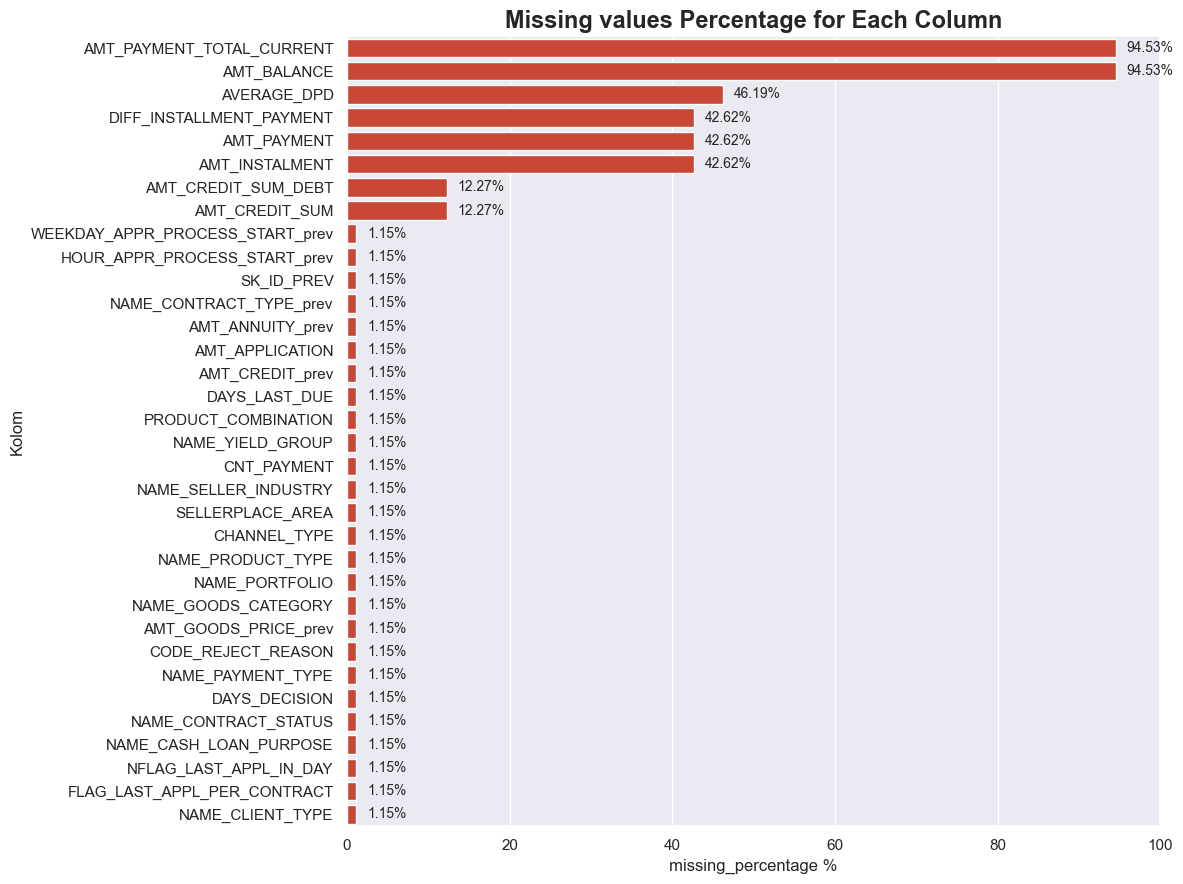

In [16]:
ms.plot_missing_percentage(train_full)

Our data Contains a lot of missing values,
- For the columns that have missing values more than 90% of the data, i will drop them.
- AVERAGE DPD missing values seems reasonable, that there's client that didn't have any DPD, or didn't have any previous application.
- for the columns `DIFF_INSTALMENT_PAYMENT`, `AMT_PAYMENT` and `AMT_INSTALMENT` i will fill the missing values with 0, because it's reasonable to assume that the client didn't have any previous application too.
- the rest of it i will leave it be, so when there's missing values, while we do woe binning, it will be treated as a separate category.

### Oulier Cheking

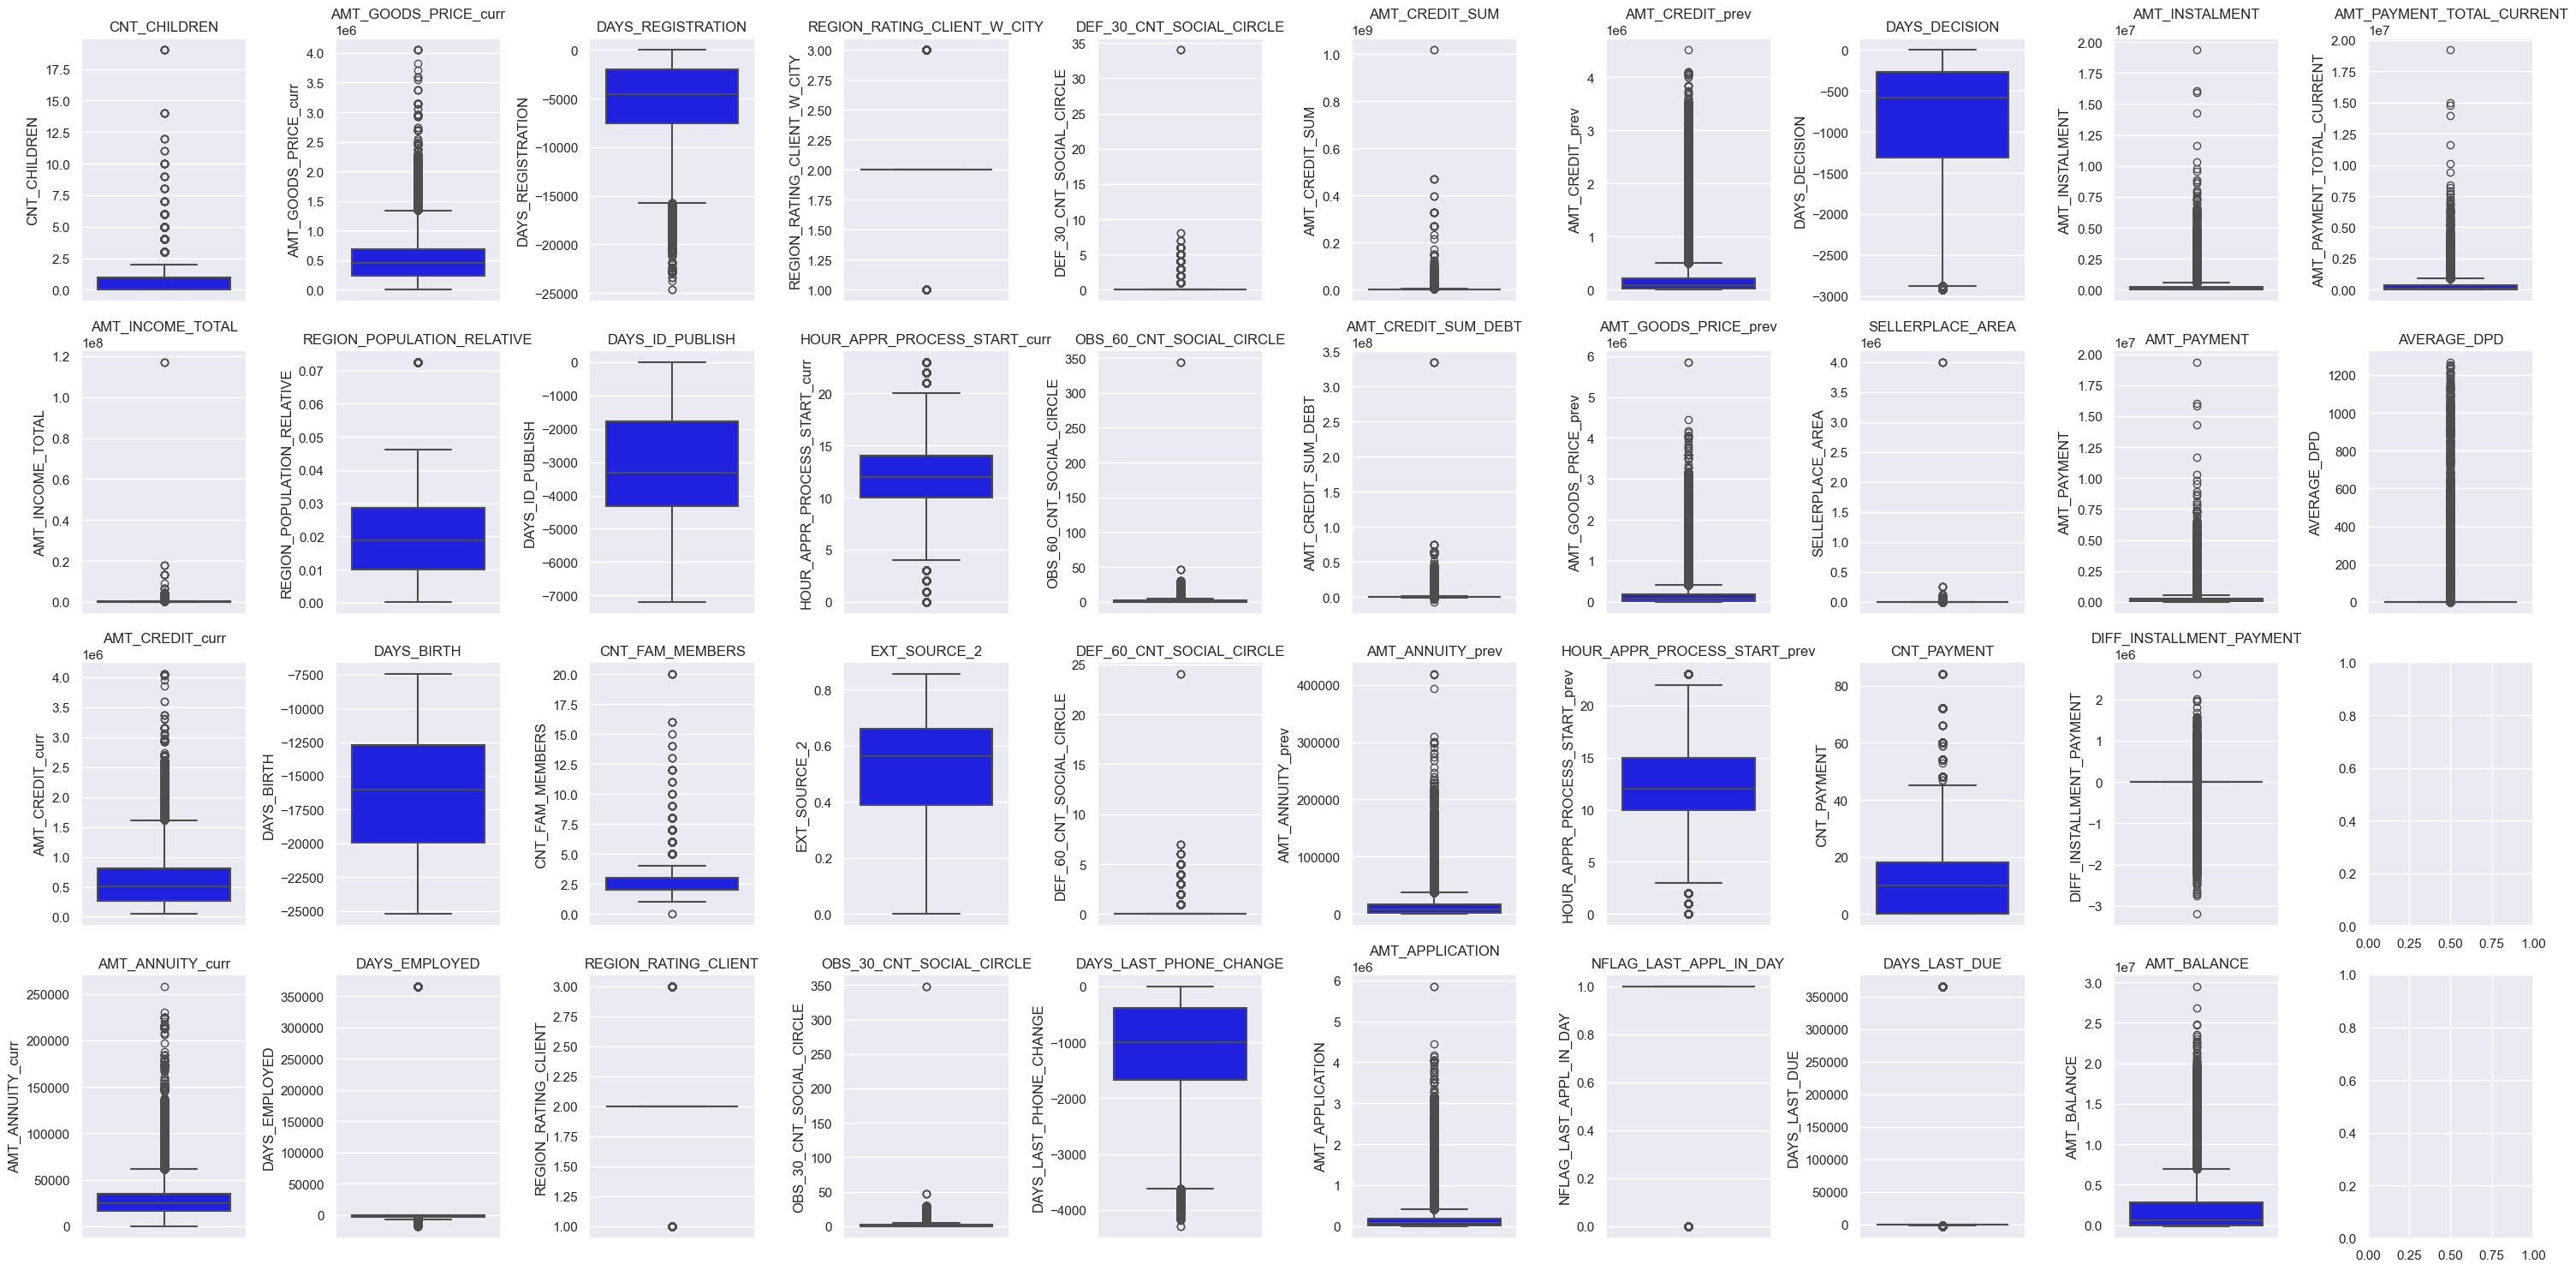

In [221]:
numvisual = train_full[[
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
    'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
    'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
    'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
    'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
    'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
    'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
    'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
    'AVERAGE_DPD'
          ]].copy()

colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# Create a 9x4 grid of subplots
fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# for each group of 4 columns
for i, group in enumerate(colgroup):
    # For eachg column in the group
    for j, column in enumerate(group):
        # Create a boxplot for the apporopriate subplot
        sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
        axs[j, i].set_title(column)

# show plot
plt.tight_layout()
plt.show()

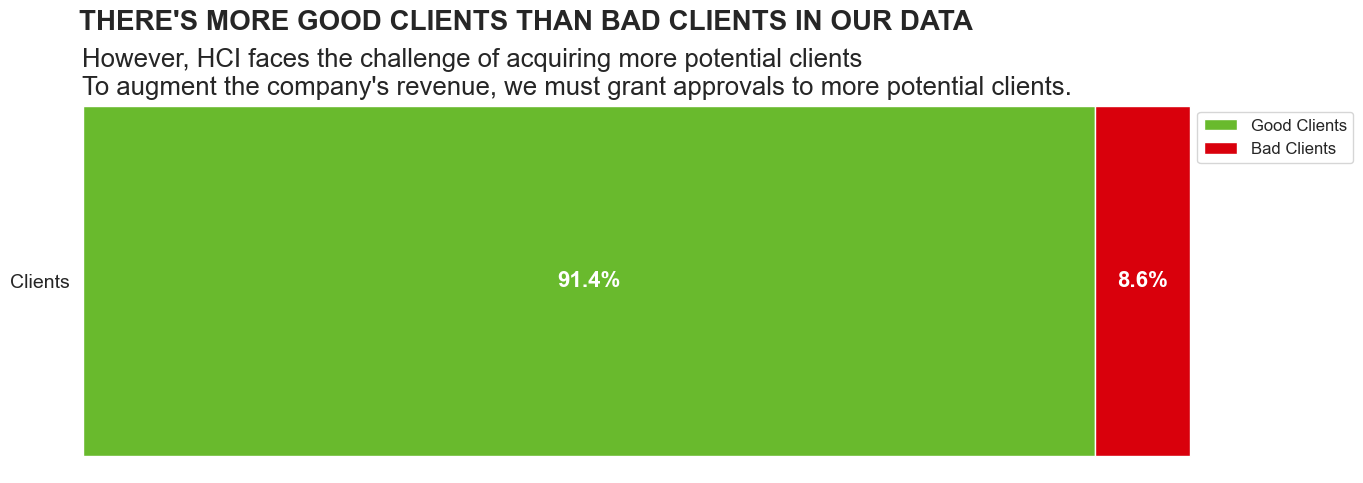

There's 1430155 Clients in our data


In [222]:
counts = train_full['TARGET'].value_counts(normalize=True)
fig, ax = plt.subplots(figsize=(15, 5))
fig.patch.set_facecolor('#FFFFFF')

gbp = ['#69ba2d', '#d9000c']

ax.barh(['Clients'], counts[0], color=gbp[0], label='Good Clients')
ax.barh(['Clients'], counts[1], left=counts[0], color=gbp[1], label='Bad Clients')
ax.set_facecolor('#FFFFFF')
sns.despine()

for i, v in enumerate(counts):
    ax.text(v/2 if i == 0 else counts[0] + v/2, 0, f'{v:.1%}', color='w', fontweight='bold', ha='center', va='center', fontsize=16)

# plt.title('Proportion of Good and Bad Clients')
# plt.text(0.5, 0.5, f'Good Clients: {counts[0]:.1%}\nBad Clients: {counts[1]:.1%}', fontsize=14, ha='center', va='center', fontweight='bold')
plt.text(0.4, 0.59, f"THERE'S MORE GOOD CLIENTS THAN BAD CLIENTS IN OUR DATA", fontsize=20, ha='center', va='center', fontweight='bold')
plt.text(-0.001, 0.425, f"However, HCI faces the challenge of acquiring more potential clients\nTo augment the company's revenue, we must grant approvals to more potential clients.", fontsize=18.5)
plt.grid(False)
plt.yticks(['Clients'], fontsize=14)
plt.xticks([])
legend = plt.legend(bbox_to_anchor=(1.1, 0.96), fontsize=12)
frame = legend.get_frame()
frame.set_facecolor('#FFFFFF')
plt.show()
print(f"There's {train_full.shape[0]} Clients in our data")

From the plot above, we can see that:
- From total 1430155 clients in our data.
- 1,306,815 (91.4%) clients don't have payment difficulties. 
- 123,340 (8.6%) clients have payments difficulties.
- The data is highly imbalanced.

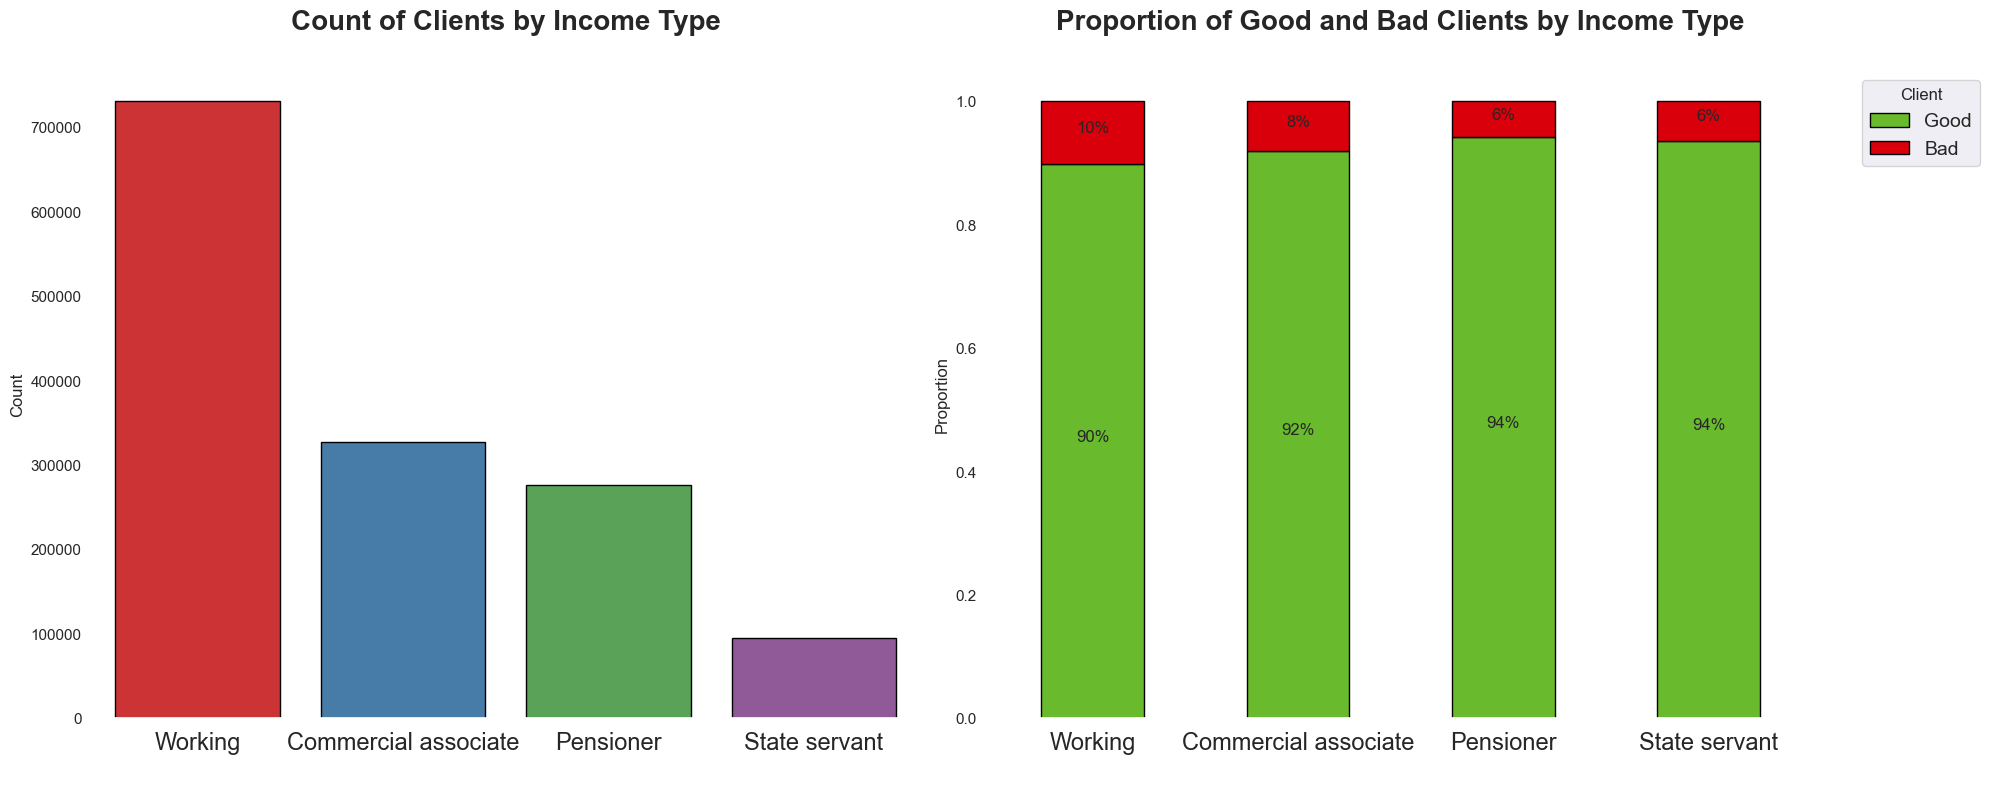

In [224]:
# Get the top 4 income types
top_4_income_types = train_full['NAME_INCOME_TYPE'].value_counts().index[:4]

# Filter the DataFrame to include only the top 4 income types
filtered_train_full = train_full[train_full['NAME_INCOME_TYPE'].isin(top_4_income_types)]

# Calculate the order of levels by value counts
order = filtered_train_full['NAME_INCOME_TYPE'].value_counts().index

fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('#FFFFFF')

# First subplot
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 cols, subplot 1
ax1.set_facecolor('#FFFFFF')
sns.countplot(x='NAME_INCOME_TYPE', data=filtered_train_full, palette='Set1', ax=ax1, order=order, edgecolor='black')
plt.grid(False)
plt.title('Count of Clients by Income Type', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=17)

ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 cols, subplot 2
ax2.set_facecolor('#FFFFFF')
gbp = ['#69ba2d', '#d9000c']
income_target = filtered_train_full.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts(normalize=True).unstack()

# Calculate value counts of 'NAME_INCOME_TYPE'
income_counts = filtered_train_full['NAME_INCOME_TYPE'].value_counts()

# Sort 'income_target' by 'income_counts'
income_target = income_target.loc[income_counts.index]

income_target.plot(kind='bar', stacked=True, color=gbp, ax=ax2, edgecolor='black')

# Add annotations
for p in ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax2.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center')

sns.despine()
plt.title('Proportion of Good and Bad Clients by Income Type', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Proportion')
plt.xticks(rotation=0, fontsize=17)
plt.grid(False)
plt.legend(title='Client', bbox_to_anchor=(1.05, 1), fontsize=14, labels=['Good', 'Bad'])

plt.tight_layout()
plt.show()

From the plot above we can infer that:
- Focus giving loan to clients that status income type is just working, because they are the most frequent client, and their the approval rate from this income type is not less than 90% wich is just fine.
- Consider giving loan to client that the income type are from Commercial associate, because they are the second most frequent client, and their the approval rate is more than client that just working.

### Client's Age default rate

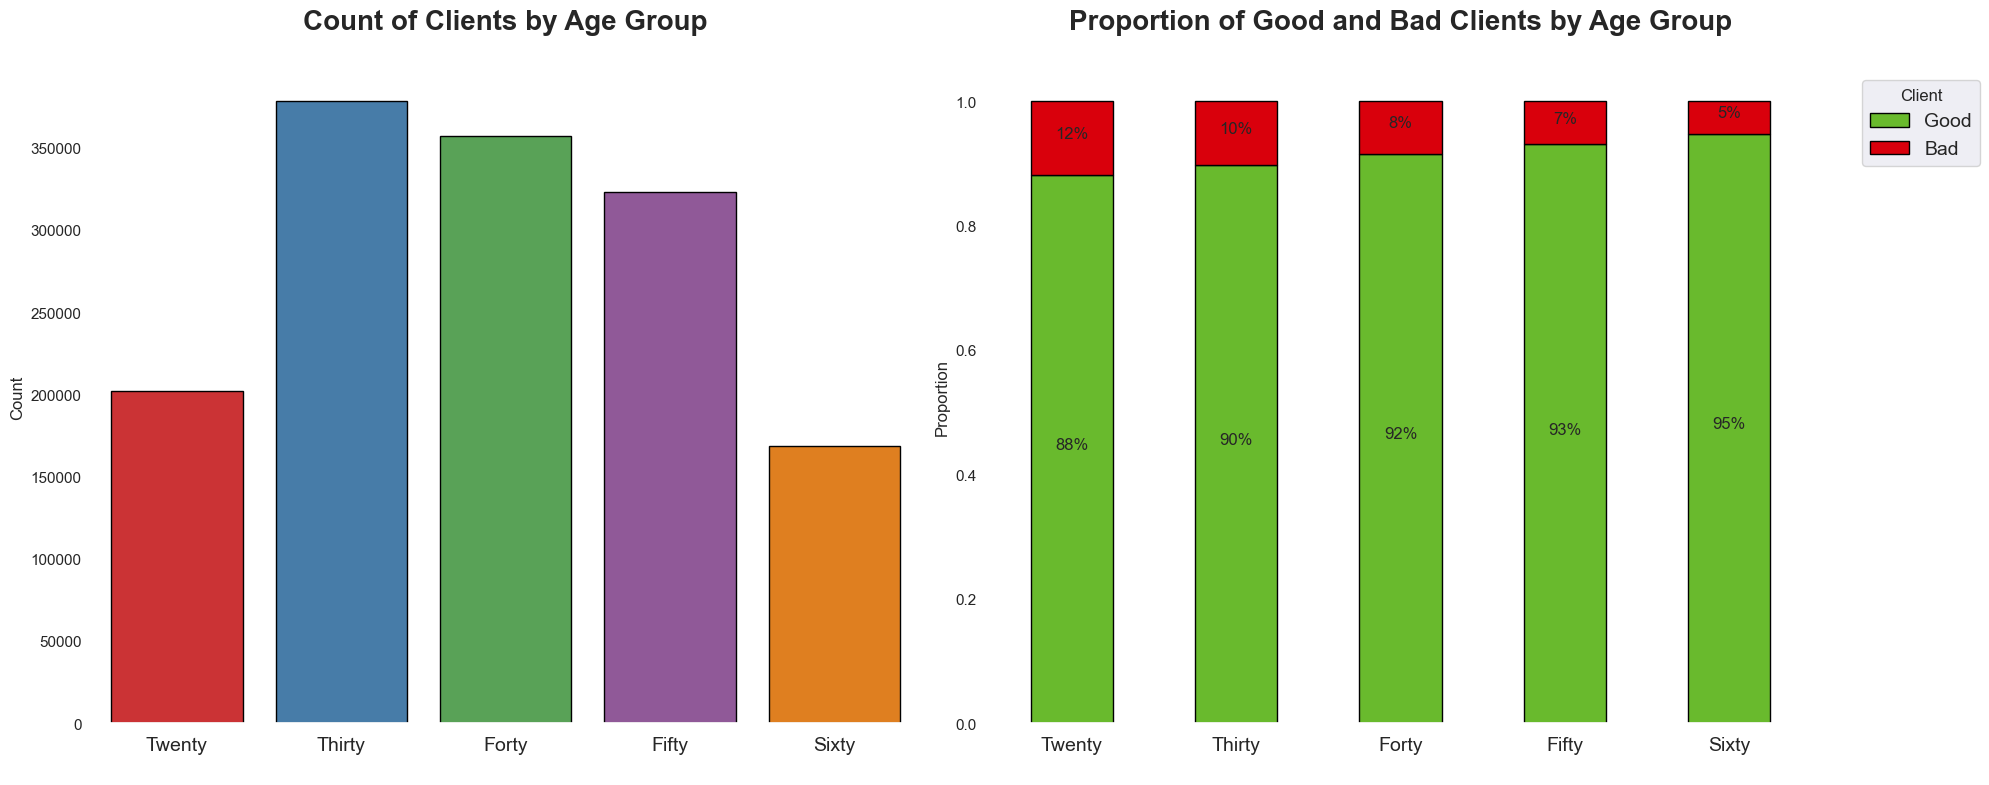

In [220]:
fig = plt.figure(figsize=(20, 8))

ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor('#FFFFFF')
sns.countplot(x='AGE_GROUP', data=train_full, palette='Set1', ax=ax1, edgecolor='black')
plt.grid(False)
plt.title('Count of Clients by Age Group', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=14)

ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor('#FFFFFF')
gbp = ['#69ba2d', '#d9000c']

age_target = train_full.groupby('AGE_GROUP')['TARGET'].value_counts(normalize=True).unstack()

# Sort the DataFrame by the index
age_target = age_target.sort_index()

age_target.plot(kind='bar', stacked=True, color=gbp, ax=ax2, edgecolor='black')

for p in ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax2.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center')

sns.despine()
plt.title('Proportion of Good and Bad Clients by Age Group', fontsize=20, fontweight='bold', y=1.05)
plt.xlabel(' ')
plt.ylabel('Proportion')
plt.xticks(rotation=0, fontsize=14)
plt.grid(False)
plt.legend(title='Client', bbox_to_anchor=(1.05, 1), fontsize=14, labels=['Good', 'Bad'])

plt.tight_layout()
plt.show()

## Train Test Split

In [38]:
X = train_full.drop(columns='TARGET', axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1072614, 79) (357539, 79) (1072614, 1) (357539, 1)


## Data filtering

In [39]:
toad.quality(X_train, target=y_train['TARGET'], iv_only=True)

,iv,gini,entropy,unique
EXT_SOURCE_2,0.286217,NaN,NaN,116293.0
DAYS_EMPLOYED,0.101107,NaN,NaN,12433.0
AMT_GOODS_PRICE_curr,0.090048,NaN,NaN,977.0
DAYS_BIRTH,0.078253,NaN,NaN,17445.0
AGE,0.077581,NaN,NaN,49.0
...,...,...,...,...
NFLAG_LAST_APPL_IN_DAY,0.000133,NaN,NaN,3.0
REG_REGION_NOT_LIVE_REGION,0.000119,NaN,NaN,2.0
FLAG_EMAIL,0.000024,NaN,NaN,2.0
FLAG_MOBIL,0.000023,NaN,NaN,2.0


In [40]:
Xtrain_selected, drop_list = toad.selection.select(frame=X_train,
                                                  target=y_train['TARGET'],
                                                  empty=0.5,
                                                  iv=0.02,
                                                  corr=0.7,
                                                  return_drop=True)

print("keep:",Xtrain_selected.shape[1],
      "drop empty:",len(drop_list['empty']),
      "drop iv:",len(drop_list['iv']),
      "drop corr:",len(drop_list['corr']))

display(Xtrain_selected)
print(f'\n{drop_list}')

keep: 24 drop empty: 7 drop iv: 42 drop corr: 6


,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
7003,M,225000.0,Working,Incomplete higher,0.018801,-9142,-746,-4016.0,-1805,2,1,Business Entity Type 3,0.402901,-1393.0,46462.500,Approved,-1393.0,6.0,high,POS household with interest,-1212.0,31133.970,5194.845,0.000000
792634,M,225000.0,Commercial associate,Secondary / secondary special,0.046220,-9036,-149,-1079.0,-1506,1,0,Business Entity Type 3,0.733094,-676.0,139437.000,Approved,-398.0,6.0,middle,POS household with interest,-217.0,96675.255,16112.745,0.714286
604873,F,225000.0,Commercial associate,Secondary / secondary special,0.014520,-11704,-732,-4347.0,-4374,2,1,Self-employed,0.344191,-238.0,533709.000,Approved,-2587.0,6.0,high,POS mobile with interest,-2402.0,22579.785,0.000,0.000000
360692,M,675000.0,Commercial associate,Higher education,0.019689,-12562,-1257,-6477.0,-3825,2,0,Business Entity Type 3,0.473022,-1438.0,220599.000,Approved,-1409.0,6.0,middle,POS household with interest,-1227.0,126868.680,21145.455,0.000000
1389608,F,238500.0,Working,Secondary / secondary special,0.035792,-14333,-983,-7818.0,-4610,2,1,Self-employed,0.020813,-602.0,35860.500,Canceled,-169.0,0.0,NaN,Cash,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,F,270000.0,Commercial associate,Incomplete higher,0.031329,-10380,-921,-4866.0,-3042,2,1,Business Entity Type 1,0.444848,-954.0,69386.355,Approved,-2380.0,6.0,high,POS mobile with interest,-2259.0,27904.050,0.000,0.000000
1419949,F,405000.0,Pensioner,Secondary / secondary special,0.025164,-20659,365243,-4696.0,-4150,2,0,NaN,0.194499,-593.0,108.000,Approved,-1155.0,0.0,NaN,Card X-Sell,-526.0,592256.520,0.000,NaN
734248,F,801000.0,State servant,Secondary / secondary special,0.015221,-14070,-6650,-8163.0,-5151,2,0,Other,0.499346,-1110.0,49782.240,Approved,-665.0,0.0,NaN,Card X-Sell,365243.0,NaN,NaN,NaN
509864,F,409500.0,Commercial associate,Secondary / secondary special,0.002134,-10528,-342,-4236.0,-185,3,1,Trade: type 7,0.239021,-872.0,NaN,Canceled,-382.0,0.0,NaN,Cash,0.0,NaN,NaN,NaN



{'empty': array(['NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON',
       'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY',
       'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT'], dtype='<U25'), 'iv': array(['SK_ID_CURR', 'NAME_CONTRACT_TYPE_curr', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START_curr',
       'HOUR_APPR_PROCESS_START_curr', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_CREDIT_SUM', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE_prev',
       'AMT_ANNUITY_prev', 'AMT_APPLICATION', 'AMT_CR

In [41]:
selected_features = Xtrain_selected.columns

X_test = X_test[selected_features]

In [43]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(Xtrain_selected, y_train['TARGET'])

df_iv.sort_values(by='iv', ascending=False)

,name,iv
0,EXT_SOURCE_2,0.286217
1,DAYS_EMPLOYED,0.101107
2,AMT_GOODS_PRICE_curr,0.090048
3,DAYS_BIRTH,0.078253
4,ORGANIZATION_TYPE,0.069430
5,AMT_CREDIT_SUM_DEBT,0.069113
6,NAME_INCOME_TYPE,0.056952
7,DAYS_LAST_PHONE_CHANGE,0.055948
8,REGION_RATING_CLIENT_W_CITY,0.046869
9,PRODUCT_COMBINATION,0.043714


## Handling Outlier

In [44]:
def cap_outliers(data, columns):
    # Create a copy of the data to avoid modifying the original DataFrame
    result = data.copy()

    # Loop over each column in the provided list
    for col in columns:
        # Calculate the first quartile (Q1) for the current column
        Q1 = result[col].quantile(0.25)
        # Calculate the third quartile (Q3) for the current column
        Q3 = result[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1
        # Calculate the lower bound for the current column
        lower_bound = Q1 - (1.5 * IQR)
        # Calculate the upper bound for the current column
        upper_bound = Q3 + (1.5 * IQR)
        # Replace values in the current column that are less than the lower bound with the lower bound
        result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
        # Replace values in the current column that are greater than the upper bound with the upper bound
        result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
    # Return the DataFrame with capped outliers
    return result


# Select the names of all numerical columns in the DataFrame X_train_c2
outliers = Xtrain_selected.select_dtypes(include='number').columns

# Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# This will cap the outliers in these columns, and the result is stored in X_train_c3
Xtrain_selected = cap_outliers(Xtrain_selected, outliers)

## Feature Binning

In [45]:
# combine x_train and y_train
train = pd.concat([Xtrain_selected, y_train], axis=1)
sample = train.sample(frac=0.25, random_state=1103)

c = toad.transform.Combiner()
c.fit(X=sample.drop('TARGET', axis=1), y=sample['TARGET'], method='dt', n_bins=None, empty_separate=True)

In [46]:
bins_output = c.export()
bins_output

{'CODE_GENDER': [['nan'], ['F'], ['M']],
 'AMT_GOODS_PRICE_curr': [138321.0,
  342411.75,
  416929.5,
  450117.0,
  461112.75,
  462789.0,
  632250.0,
  675191.25,
  677889.0],
 'NAME_INCOME_TYPE': [['Pensioner'],
  ['State servant'],
  ['Commercial associate'],
  ['Working'],
  ['Student', 'Businessman'],
  ['Maternity leave'],
  ['Unemployed']],
 'NAME_EDUCATION_TYPE': [['Academic degree'],
  ['Higher education'],
  ['Incomplete higher'],
  ['Secondary / secondary special'],
  ['Lower secondary']],
 'REGION_POPULATION_RELATIVE': [0.0007354999834205955,
  0.002319999970495701,
  0.017320500686764717,
  0.018118999898433685,
  0.018825500272214413,
  0.019967499189078808,
  0.021668999455869198,
  0.0319449994713068,
  0.05141475051641464],
 'DAYS_BIRTH': [-23244.5,
  -19914.5,
  -14786.5,
  -14745.5,
  -14744.5,
  -13426.5,
  -11602.5,
  -8783.5,
  -8579.5],
 'DAYS_EMPLOYED': [-4572.5,
  -4571.5,
  -3047.5,
  -1475.5,
  -1472.5,
  -933.5,
  -923.5,
  -15.5,
  1766.0],
 'DAYS_REGISTRAT

## Transform WoE

In [47]:
# intialize the WOE transformer
td = toad.transform.WOETransformer()

# Transform the data into WoE values
Xtrain_selected_woe = td.fit_transform(c.transform(Xtrain_selected), y_train['TARGET'])

# transform test set
Xtest_selected_woe = td.fit_transform(c.transform(X_test), y_test['TARGET'])

# Calculate the Information Value (IV) for each feature
iv = toad.quality(Xtrain_selected_woe, y_train['TARGET'], iv_only=True)

iv

,iv,gini,entropy,unique
EXT_SOURCE_2,0.283937,NaN,NaN,10.0
DAYS_EMPLOYED,0.096193,NaN,NaN,10.0
AMT_GOODS_PRICE_curr,0.085123,NaN,NaN,10.0
DAYS_BIRTH,0.077075,NaN,NaN,10.0
ORGANIZATION_TYPE,0.067394,NaN,NaN,10.0
AMT_CREDIT_SUM_DEBT,0.066610,NaN,NaN,11.0
NAME_INCOME_TYPE,0.056963,NaN,NaN,7.0
DAYS_LAST_PHONE_CHANGE,0.054603,NaN,NaN,10.0
PRODUCT_COMBINATION,0.043324,NaN,NaN,10.0
REGION_POPULATION_RELATIVE,0.042742,NaN,NaN,10.0


## Model building

In [51]:
def eval_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)

    pred_train = model.predict_proba(X_train)[:, 1]
    pred_test = model.predict_proba(X_test)[:, 1]

    print('Train AUC:', AUC(pred_train, y_train))
    print('Test AUC:', AUC(pred_test, y_test))

    print('Train Recall:', recall_score(y_train, pred_train > 0.88))
    print('Test Recall:', recall_score(y_test, pred_test > 0.88))

    print('Train Precision:', precision_score(y_train, pred_train > 0.88))
    print('Test Precision:', precision_score(y_test, pred_test > 0.88))

    fig, ax = plt.subplots(figsize=(11, 5))
    
    fpr, tpr, _ = roc_curve(y_test, pred_test)
    roc_auc = roc_auc_score(y_test, pred_test)

    # Plot ROC Curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate the precision-recall curve points
    precision, recall, _ = precision_recall_curve(y_test, pred_test)
    
    # Calculate the average precision score
    avg_precision = average_precision_score(y_test, pred_test)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall curve (Average Precision = %0.2f)' % avg_precision, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
# initialize the lightgbm classifier
lgbm = LGBMClassifier(n_estimators=100, random_state=1103, class_weight='balanced')

eval_model(lgbm, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

lr = LogisticRegression(random_state=1103, class_weight='balanced')
eval_model(lr, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

Train AUC: 0.7116591193633091
Test AUC: 0.7142226377348951
Train Recall: 0.017124879725828945
Test Recall: 0.01945336056803813
Train Precision: 0.46261682242990654
Test Precision: 0.4854368932038835


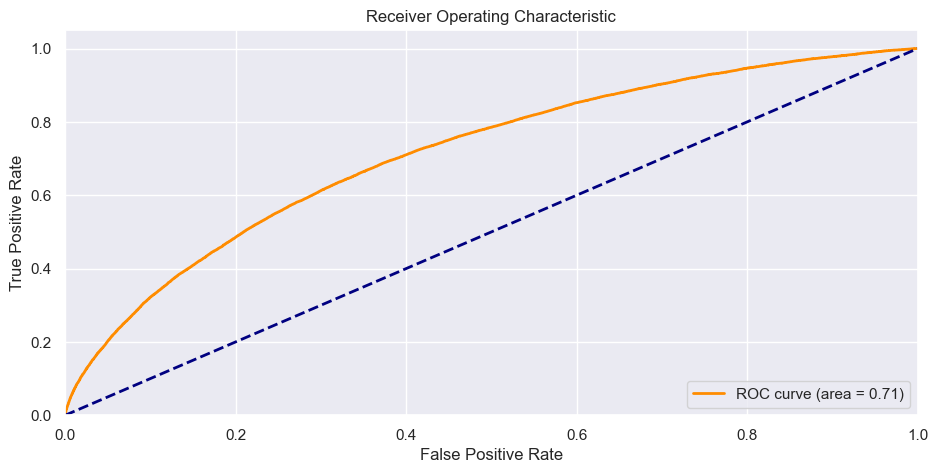

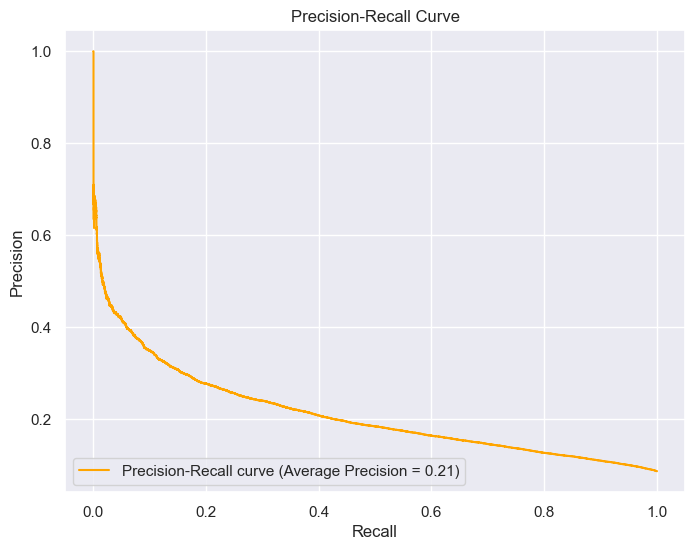

In [52]:
lr = LogisticRegression(random_state=1103, class_weight='balanced')
eval_model(lr, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

[LightGBM] [Info] Number of positive: 92497, number of negative: 980117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 1072614, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train AUC: 0.7460179203926619
Test AUC: 0.7380312508275124
Train Recall: 0.010140869433603253
Test Recall: 0.010861459650487956
Train Precision: 0.6624293785310734
Test Precision: 0.6517509727626459


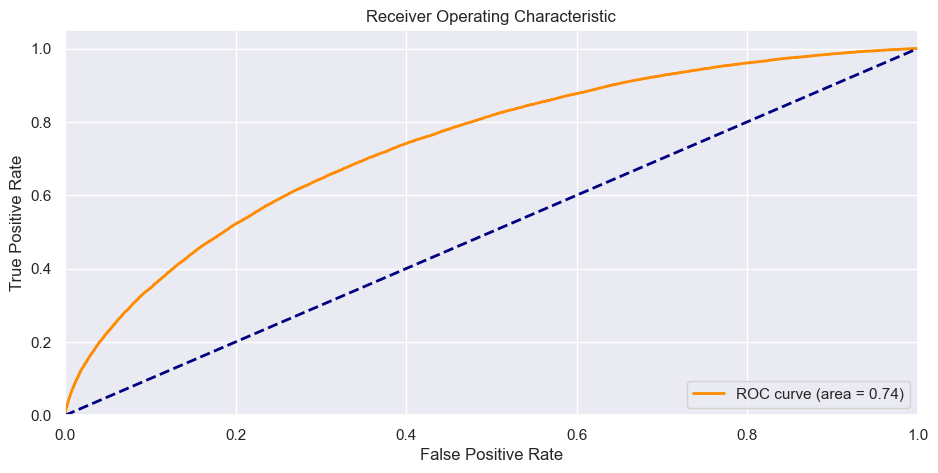

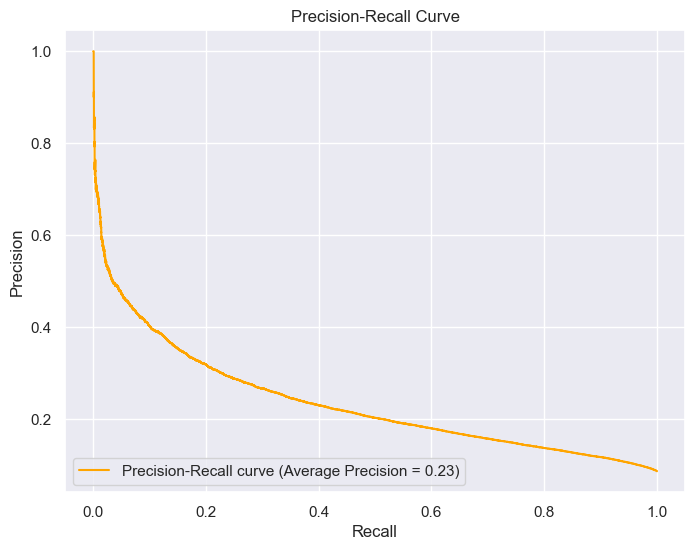

In [60]:
# initialize the lightgbm classifier
lgbm = LGBMClassifier(n_estimators=100, random_state=1103, class_weight='balanced')

eval_model(lgbm, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

## Hyperparameter Tuning

In [61]:
# hyperparameter tuning lightgbm
num_leaves = [int(x) for x in np.linspace(start=20, stop=150, num=10)]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]

# Create the random grid
random_grid = {'num_leaves': num_leaves,
               'max_depth': max_depth}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm = LGBMClassifier(n_estimators=100, random_state=1103, class_weight='balanced')
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
lgbm_result = RandomizedSearchCV(estimator=lgbm, param_distributions=random_grid, n_iter=100, cv=3, random_state=1103)

# print the best parameters
lgbm_result.fit(Xtrain_selected_woe, y_train)
lgbm_result.best_params_

[LightGBM] [Info] Number of positive: 61665, number of negative: 653411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 715076, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

{'num_leaves': 150, 'max_depth': 30}

In [225]:
# logistic regression hyperparameter tuning
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']

# Create the random grid
random_grid = {'penalty': penalty,
               'C': C,
               'solver': solver}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
lr = LogisticRegression(random_state=1103, class_weight='balanced')
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
lr_result = RandomizedSearchCV(estimator=lr, param_distributions=random_grid, n_iter=100, cv=3, random_state=1103)

# print the best parameters
lr_result.fit(Xtrain_selected_woe, y_train)
lr_result.best_params_

{'solver': 'saga', 'penalty': 'l1', 'C': 0.001}

In [ ]:
# Assgn the best parameters to logistic regression
lr_tuned = LogisticRegression(random_state=1103, class_weight='balanced', **lr_result.best_params_)
eval_model(lr_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

[LightGBM] [Info] Number of positive: 92497, number of negative: 980117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1072614, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train AUC: 0.8167357587981856
Test AUC: 0.7850056259347101
Train Recall: 0.022422348832935122
Test Recall: 0.01993969458223908
Train Precision: 0.8057498057498057
Test Precision: 0.7765151515151515


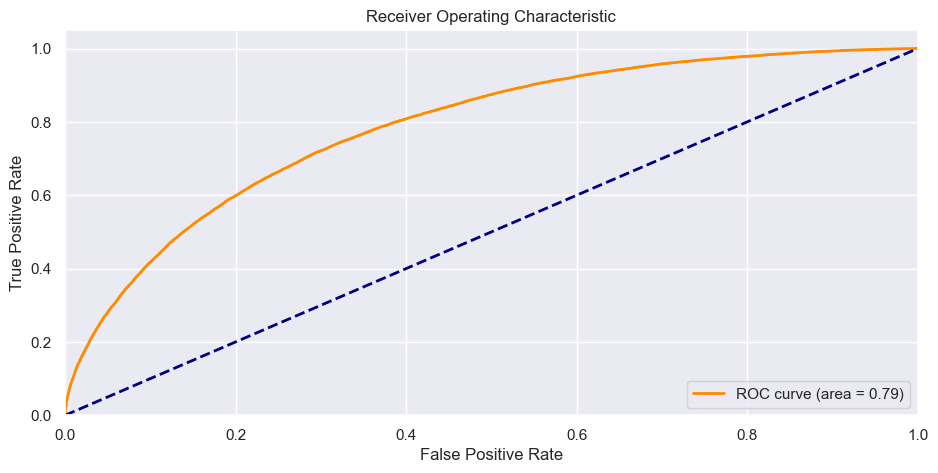

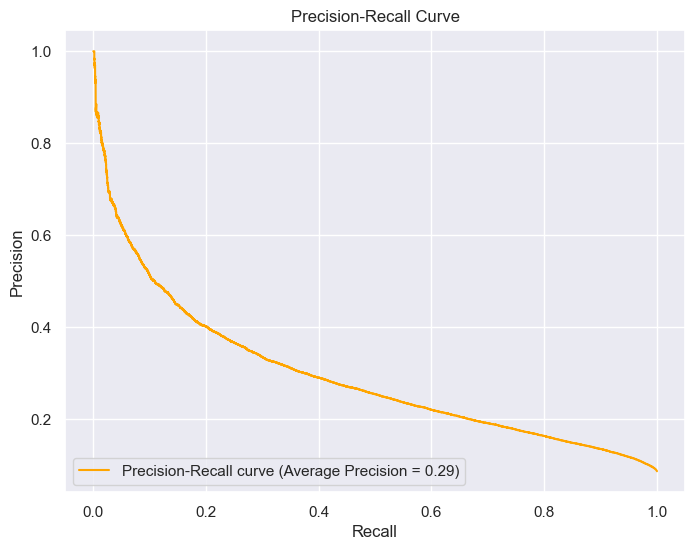

In [62]:
# assign best hyperparameter to lightgbm
lgbm_tuned = LGBMClassifier(random_state=1130, class_weight='balanced', **lgbm_result.best_params_)
eval_model(lgbm_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

In [227]:
def df_model_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_predict_proba = model.predict_proba(X_train)[:, 1]
    test_predic_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_preds)
    test_auc = roc_auc_score(y_test, test_preds)
    
    train_precision = precision_score(y_train, train_predict_proba > 0.88)
    test_precision = precision_score(y_test, test_predic_proba > 0.88)
    
    return train_auc, test_auc, train_precision, test_precision

# Assgn the best parameters to logistic regression
lr_tuned = LogisticRegression(random_state=1103, class_weight='balanced', **lr_result.best_params_)
# assign best hyperparameter to lightgbm
lgbm_tuned = LGBMClassifier(random_state=1130, class_weight='balanced', **lgbm_result.best_params_)

# Evaluate the models and store the scores
lgbm_scores = df_model_score(lgbm_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)
lr_scores = df_model_score(lr_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test)

# Create a DataFrame to store the scores
scores_df = pd.DataFrame(data=[lgbm_scores, lr_scores], 
                         columns=['Train AUC', 'Test AUC', 'Train Precision', 'Test Precision'], 
                         index=['LGBM', 'Logistic Regression'])

scores_df

[LightGBM] [Info] Number of positive: 92497, number of negative: 980117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 1072614, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,Train AUC,Test AUC,Train Precision,Test Precision
LGBM,0.736705,0.710028,0.805750,0.776515
Logistic Regression,0.653345,0.655189,0.491569,0.506524


In [74]:
# def adjust_threshold(model, X, threshold):
#     return (model.predict_proba(X)[:,1] >= threshold).astype(int)

# y_pred_adjusted = adjust_threshold(lgbm_tuned, Xtest_selected_woe, 0.88)
# y_pred_train_adjusted = adjust_threshold(lgbm_tuned, Xtrain_selected_woe, 0.88)

# # Calculate and print the precision
# precision = precision_score(y_test, y_pred_adjusted)
# print(f'Precision Train: {precision_score(y_train, y_pred_train_adjusted)}')
# print(f'Precision Test: {precision}')

# # Calculate and print the recall
# recall = recall_score(y_test, y_pred_adjusted)
# print(f'Recall Train: {recall_score(y_train, y_pred_train_adjusted)}')
# print(f'Recall Test: {recall}')

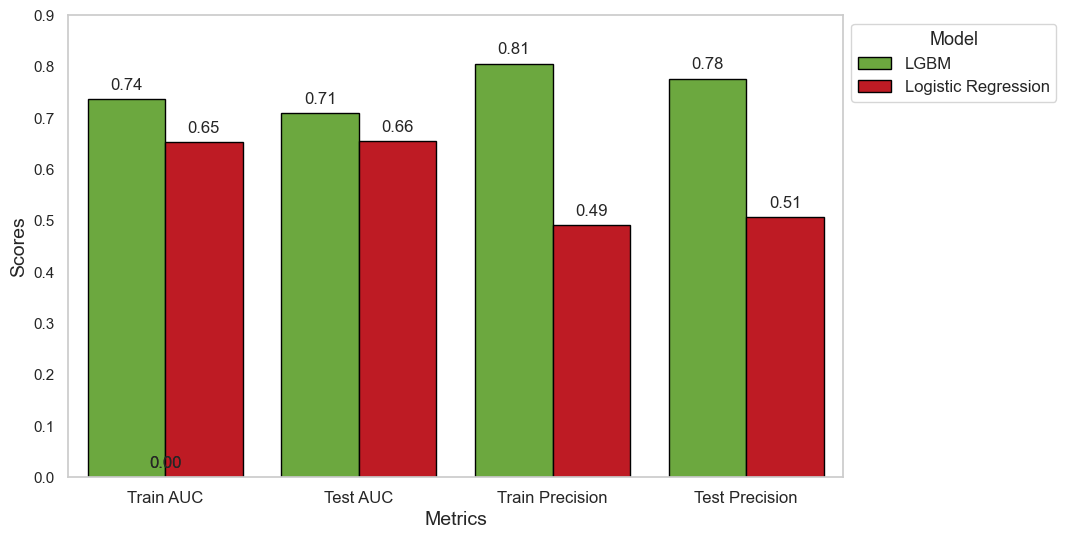

In [243]:
# Melt the DataFrame to long format for seaborn
long_scores_df = scores_df.reset_index().melt(id_vars='index', var_name='Metrics', value_name='Scores')

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")  # Set the background color to white
barplot = sns.barplot(x='Metrics', y='Scores', hue='index', data=long_scores_df, palette=gbp, edgecolor='black')

# Add annotations
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 10), 
                     textcoords = 'offset points')

plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
# plt.title('Final Model Scores Comparison', fontsize=16, fontweight='bold', y=1.05)
plt.xticks(fontsize=12)
plt.legend(title='Model', title_fontsize='13', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(False)
plt.ylim(0, 0.9)
plt.show()

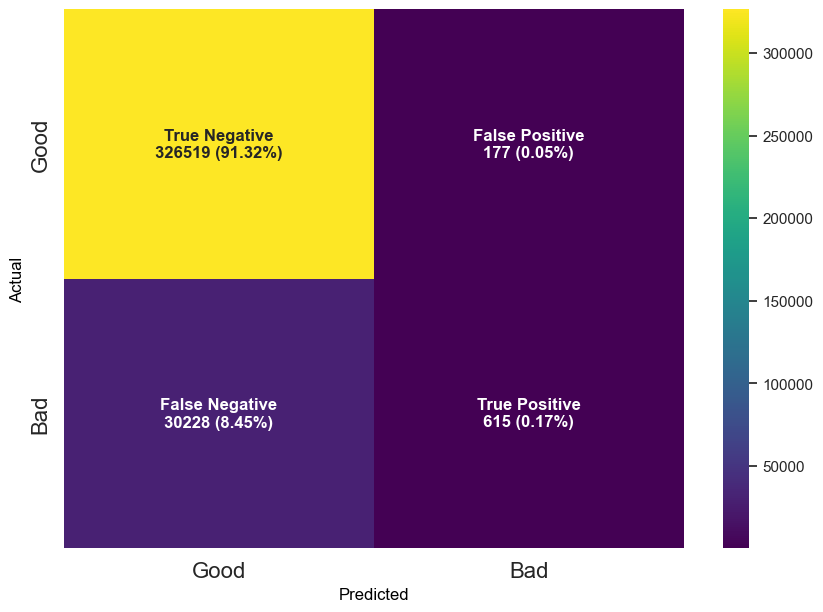

In [250]:
pred_test = lgbm_tuned.predict_proba(Xtest_selected_woe)[:, 1]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_test > 0.88)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
# plt.title('Confusion Matrix LightGBM Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.xticks(ticks=[0.5, 1.5], labels=['Good', 'Bad'], fontsize=16)
plt.yticks(ticks=[0.5, 1.5], labels=['Good', 'Bad'], fontsize=16)
plt.show()

## Feature Importances

In [ ]:
# Create a TreeExplainer
explainer = shap.TreeExplainer(lgbm_tuned)

# Calculate SHAP values
shap_values = explainer.shap_values(Xtrain_selected_woe)

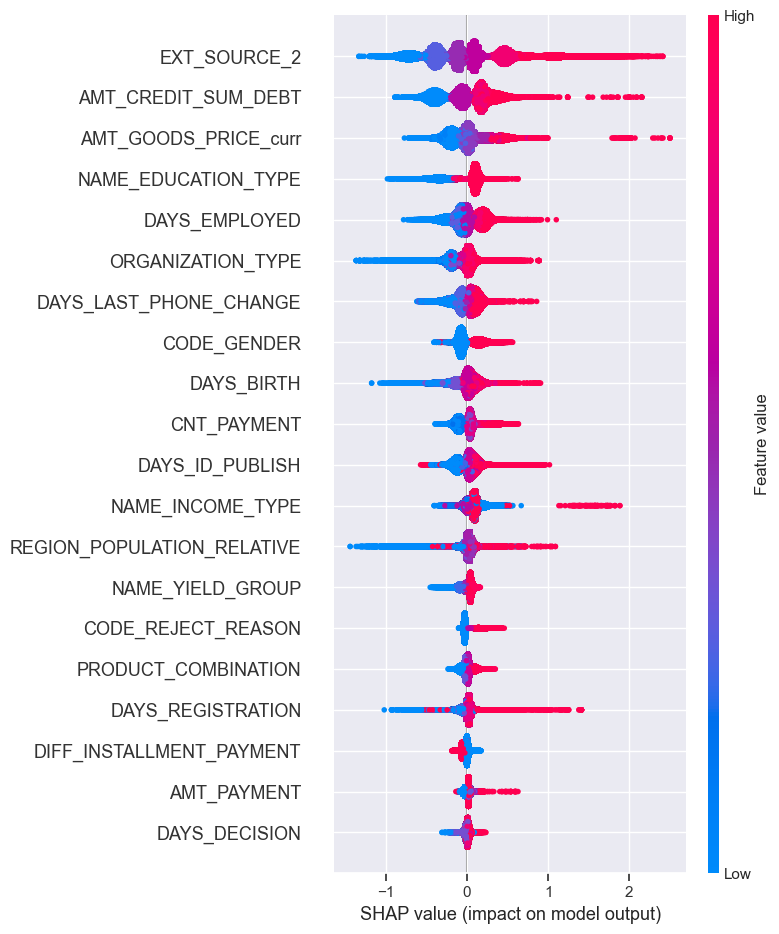

In [164]:
# Plot feature importance
shap.summary_plot(shap_values[1], Xtrain_selected_woe)

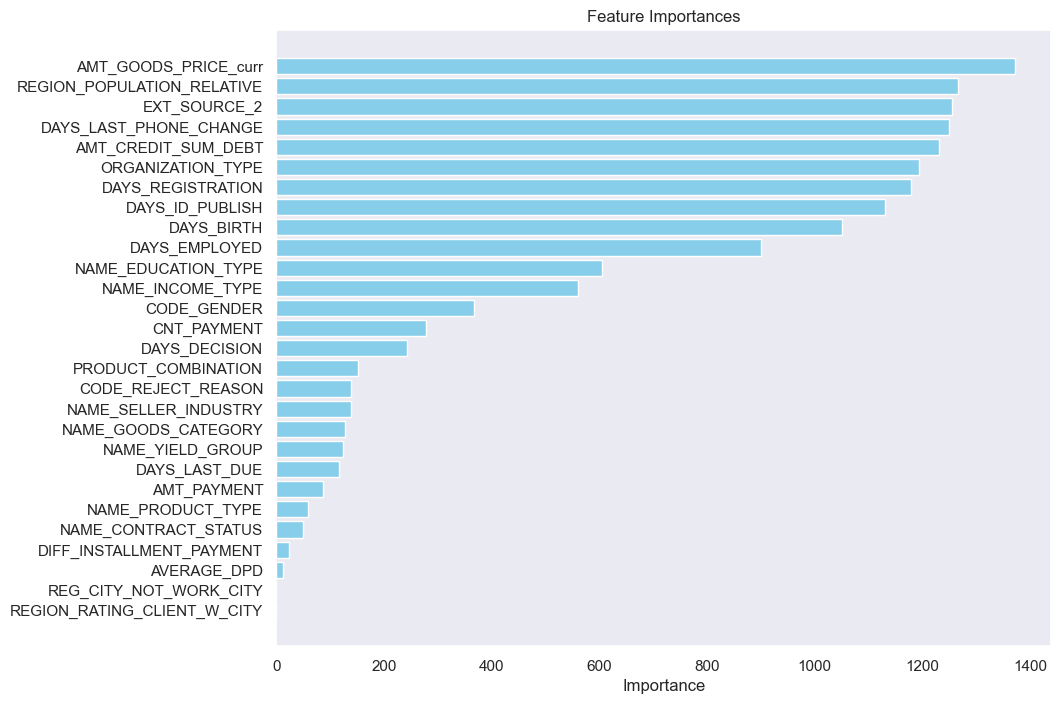

In [140]:
# Get feature importances
importances = lgbm_tuned.feature_importances_

# Create a DataFrame for feature importances
feat_importances = pd.DataFrame({'Feature': Xtrain_selected_woe.columns, 'Importance': importances})

# Sort by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
feat_importances_sorted = feat_importances.sort_values(by='Importance', ascending=True)
plt.barh(feat_importances_sorted['Feature'], feat_importances_sorted['Importance'], color='skyblue')
plt.grid(False)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [251]:
# Get the prediction probabilities for the positive class
probabilities = lgbm_tuned.predict_proba(Xtrain_selected_woe)[:, 1]

# Define the scaling factor and offset
factor = 20 / np.log(2)
offset = 600 - factor * np.log(20)

# Scale the probabilities
scores = probabilities * factor + offset

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_train['TARGET'], scores)

# Calculate the Youden's J statistic for each point on the ROC curve
J = tpr - fpr

# Find the optimal cutoff point
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx] / 1000

print(f'Optimal cutoff point: {optimal_threshold}')

Optimal cutoff point: 0.5275371493210872


In [63]:
# # Get the coefficients and intercept from the logistic regression model
# coefficients = lr_tuned.coef_[0]
# intercept = lr_tuned.intercept_[0]

# # Define the scaling factor and offset
# pdo = 80
# base_odds = 35
# base_score = 1000
# factor = pdo / np.log(2)
# offset = base_score - factor * np.log(base_odds)

# # Calculate the score for each feature
# scores = pd.DataFrame(index=Xtrain_selected_woe.index)

# for i in range(len(Xtrain_selected_woe.columns)):
#     feature = Xtrain_selected_woe.columns[i]
#     scores[feature] = (coefficients[i] * Xtrain_selected_woe[feature] + intercept / len(Xtrain_selected_woe.columns)) * factor + offset / len(Xtrain_selected_woe.columns)

# # Calculate the total score for each row
# scores['Total Score'] = scores.sum(axis=1)

In [253]:
# Define the scaling factor and offset
pdo = 20
base_odds = 35
base_score = 600
factor = pdo / np.log(2)
offset = base_score - factor * np.log(base_odds)

# Calculate the score for each feature
scorecard = pd.DataFrame(index=Xtrain_selected_woe.index)

for i in range(len(Xtrain_selected_woe.columns)):
    feature = Xtrain_selected_woe.columns[i]
    # Calculate the SHAP value for this feature for each observation
    scorecard[feature] = shap_values[1][:, i] * factor + offset

# Calculate the total score for each row
scorecard['Total Score'] = scores.sum(axis=1)

In [181]:
cutoff_thresholds = 579
# Classify the clients based on the optimal threshold
scorecard['Classification'] = ['good' if score >= cutoff_thresholds else 'bad' for score in scores['Total Score']]

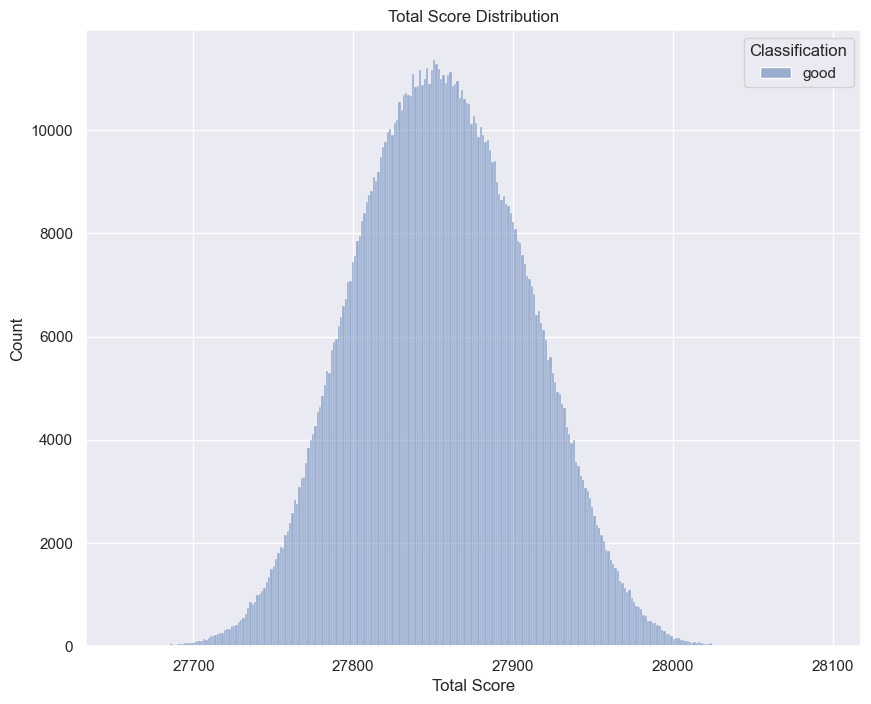

In [183]:
plt.figure(figsize=(10, 8))
sns.histplot(data=scorecard, x='Total Score', hue='Classification')
# plt.axvline(x=cutoff_thresholds, color='red', linestyle='--')
plt.title('Total Score Distribution')
plt.show()


In [75]:
scores.Classification.value_counts()

Classification
good    950087
bad     122527
Name: count, dtype: int64